In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from functools import lru_cache
import os
from scipy.spatial.distance import pdist, squareform

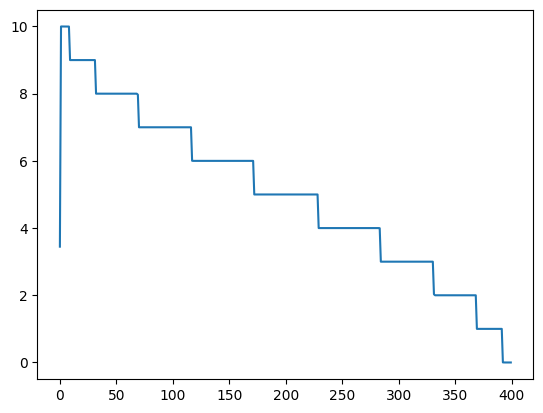

In [2]:
pris = np.loadtxt(os.path.expanduser('~/Downloads/transmissions/size_10/size_10_pris.csv'), delimiter=',')
plt.plot(pris)

In [3]:
size = 10
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(5000):
        path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
        df[x] = new_data
    df = pd.DataFrame(df)
#    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=size)


DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, size, config):
    width = int(size); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [4]:
print("Creating manifest file...")

# This will store the info for each s#ample
manifest_data = []
# Define the root directory where files are stored
root_dir = os.path.expanduser('~/Downloads/transmissions/size_10/')

# Use the same loops as your original script
for conc in np.arange(7, 50, 2):
    for config in range(5000):
        # We just construct the path, we don't load the file here
        path = f'lead_size_10_conc_{conc}_config_{config}.csv'
        full_path = os.path.join(root_dir, path)

        # Check if the file actually exists before adding it to the manifest
        if os.path.exists(full_path):
            manifest_data.append({
                "concentration": conc,
                "config_id": config,
                "filepath": path  # Store the relative path
            })

# Convert the list of data into a pandas DataFrame
manifest_df = pd.DataFrame(manifest_data)

# Save the manifest to a CSV file
manifest_df.to_csv("manifest.csv", index_label="id")

print(f"Done! Created manifest.csv with {len(manifest_df)} entries.")

Creating manifest file...
Done! Created manifest.csv with 110000 entries.


In [5]:
class transmissions_dataset(Dataset):
    def __init__(self,manifest_file, root_dir,matrix_size=50,pris_file='~/Downloads/transmissions/size_10/size_10_pris.csv'):
        print("Initializing dataset...")
        self.manifest = pd.read_csv(manifest_file,index_col="id")
        self.root_dir = root_dir
        self.matrix_size = matrix_size
        self.pris = np.loadtxt(os.path.expanduser(pris_file), delimiter=',')
        print("dataset_ready")

    def __len__(self):
        print("Getting length of dataset...")
        print(f"Length: {len(self.manifest)}")
        return len(self.manifest)
    def __getitem__(self, idx):
        sample_info = self.manifest.iloc[idx]
        conc = sample_info['concentration']
        config = sample_info['config_id']
        filepath = os.path.join(self.root_dir, sample_info['filepath'])
        print(f"Loading data from {filepath}...")
        print(f"Concentration: {conc}, Config ID: {config}")


        #"Get distance matrix"
        dist_mat = 0 *np.eye(self.matrix_size)
        dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
        x = torch.tensor(dist_mat, dtype=torch.float32)

        #"Get transmission data"
        new_data = np.loadtxt(filepath, delimiter=',',skiprows=1)[:,1]
        y = torch.tensor(np.clip(new_data, 0, self.pris), dtype=torch.float32)


        return x, y

In [6]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

In [7]:
from torch_geometric.data import Data

In [13]:
a = distance_matrix(50,0)

In [9]:
import networkx as ntx

In [17]:
a

array([[ 3.        , 15.23154621, 70.17834424, ..., 85.02352616,
        68.0661443 , 41.19465985],
       [15.23154621,  1.        , 56.00892786, ..., 71.44928271,
        54.08326913, 27.07397274],
       [70.17834424, 56.00892786,  2.        , ..., 16.55294536,
         2.82842712, 29.01723626],
       ...,
       [85.02352616, 71.44928271, 16.55294536, ...,  1.        ,
        17.72004515, 44.40720662],
       [68.0661443 , 54.08326913,  2.82842712, ..., 17.72004515,
         4.        , 27.01851217],
       [41.19465985, 27.07397274, 29.01723626, ..., 44.40720662,
        27.01851217,  3.        ]], shape=(50, 50))

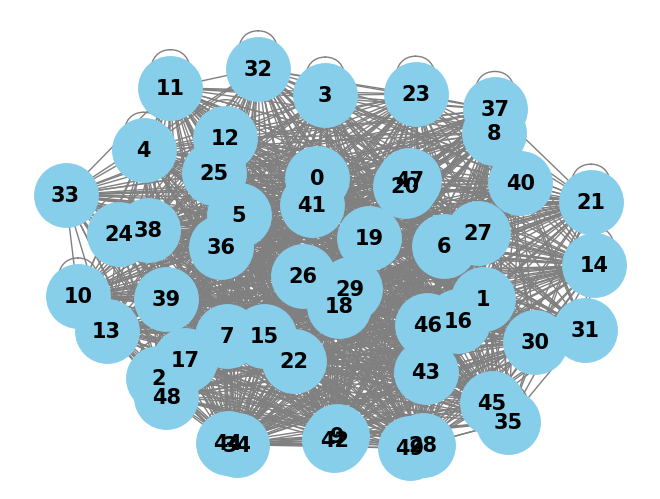

In [15]:
ntx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, 
        edge_color='gray', linewidths=2, font_size=15, 
        font_weight='bold')